In [36]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from mne.io import read_raw_fif
import matplotlib.pyplot as plt

%matplotlib inline

ptb_data = pd.read_csv(Path("../data/240hz/framerate_test_fliptimes_ptb.csv"))
logger_data = pd.read_pickle(Path("../data/240hz/framerate_flicker_test_logger.pkl"))
raw_data = read_raw_fif(
    Path("../data/240hz/berk_framerate_test_240hz_with_logger.fif"), preload=True
)

ptb_diffs = pd.DataFrame(np.diff(ptb_data.values.flatten()), columns=["flip_times"])
logger_diffs = pd.DataFrame(
    np.diff(logger_data["continuous"][1]["frame_flips"]), columns=["logger_times"]
)
alldiffs = ptb_diffs.join(logger_diffs)
meltdiffs = alldiffs.melt(value_name="times", var_name="source")
meltdiffs["freqs"] = 1 / meltdiffs["times"]

Opening raw data file ../data/240hz/berk_framerate_test_240hz_with_logger.fif...
Isotrak not found
    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 104000 ... 340999 =     20.800 ...    68.200 secs
Ready.
Reading 0 ... 23699

/var/folders/6x/cg6jvt750xl8q9tkh9t3fhfh0000gn/T/ipykernel_85167/200343981.py:13: RuntimeWarning: This filename (../data/240hz/berk_framerate_test_240hz_with_logger.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data = read_raw_fif(


['MISC010', 'STI101', 'SYS201']


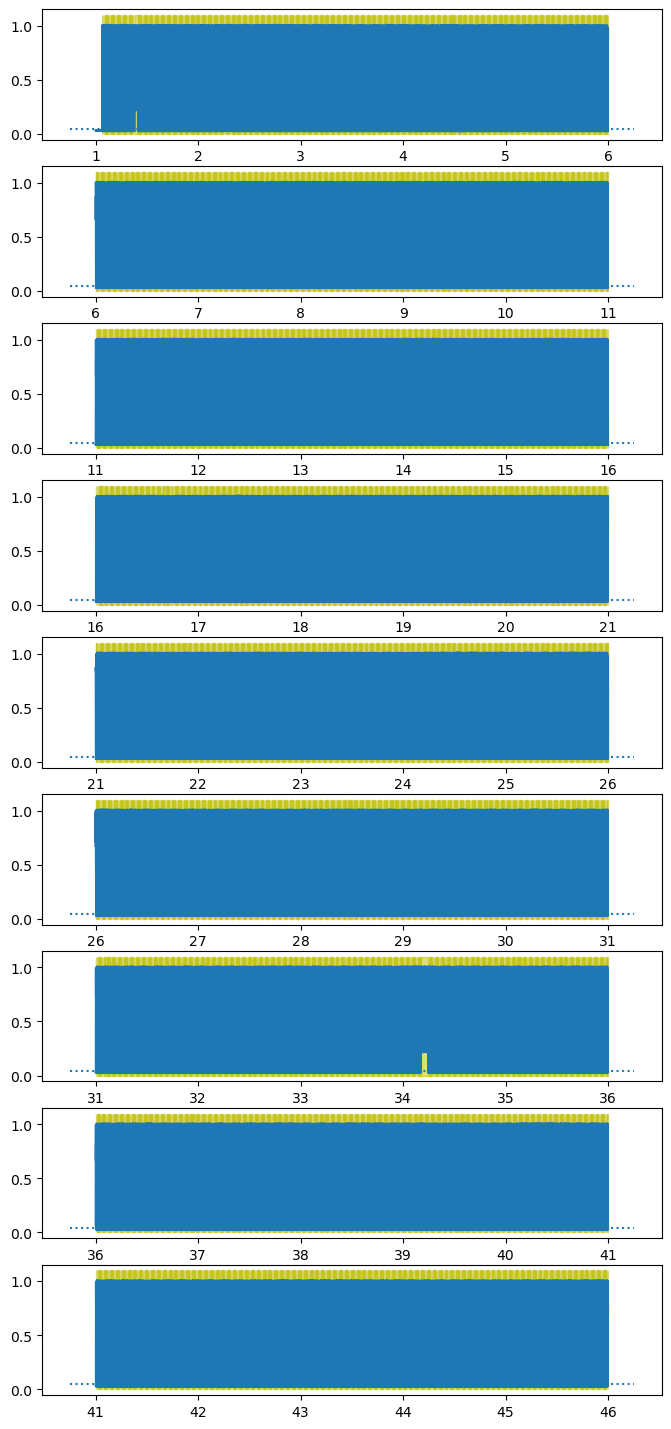

In [34]:
print(raw_data.ch_names)
off_thresh = 4.5e-2
photodiode, times = raw_data.get_data(["MISC010"], start=1 * 5000, return_times=True)
windows = np.arange(1.0, times.max(), 5.0)
windows = np.vstack([windows[:-1], windows[1:]]).T
fig, ax = plt.subplots(len(windows), figsize=(8, 2 * len(windows)))
i = 0
for min_t, max_t in windows:
    mask = (times < max_t) & (times >= min_t)
    ons = (photodiode.T[mask] > off_thresh).flatten()
    ax[i].plot(times[mask], photodiode.T[mask])
    ax[i].hlines(off_thresh, *ax[i].get_xlim(), ls=":")
    ax[i].fill_between(
        times[mask],
        np.zeros(mask.sum()),
        np.ones(mask.sum()) * 1.1,
        where=ons,
        color="y",
        alpha=0.5,
    )
    i += 1


In [41]:
print((ptb_data - ptb_data.iloc[0]).max())
print(max(logger_data["continuous"][1]["frame_flips"]))

0    14.99649
dtype: float64
15.003725051879883
